In [1]:
from influxdb_client import InfluxDBClient

import pandas as pd

from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA, ARMA

import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

## Get data

In [8]:
df = pd.read_csv("dataframe_10g_5m.csv")
df = df.drop('people', 1)
df.time = pd.to_datetime(df.time, dayfirst = True)
df.set_index('time',inplace=True)
points_per_day = 288 
df.tail()

,temperature,humidity,pressure
time,,,
2020-07-17 13:15:00+00:00,29.40,54.4,1016.5
2020-07-17 13:20:00+00:00,29.30,54.2,1016.5
2020-07-17 13:25:00+00:00,29.35,54.3,1016.5
2020-07-17 13:30:00+00:00,29.20,54.3,1016.5
2020-07-17 13:35:00+00:00,29.20,54.5,1016.5


## Get the d param

In [9]:
from pmdarima.arima import ndiffs
kpss_diff = ndiffs(df['temperature'].values, alpha=0.05, test='kpss', max_d=12)
adf_diff = ndiffs(df['temperature'].values, alpha=0.05, test='adf', max_d=12)
n_diffs = max(adf_diff , kpss_diff )
n_diffs

1

## Visualize the period

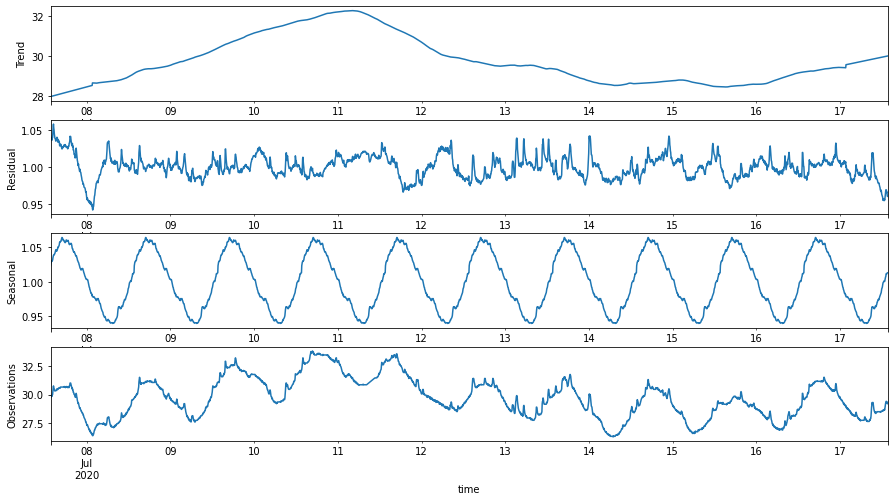

In [10]:
import statsmodels.api as sm

decomposition = sm.tsa.seasonal_decompose(df['temperature'], model='multiplicative', 
                            extrapolate_trend='freq',
                                         period=288) #additive or multiplicative is data specific

fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(15,8))

ax1.set_ylabel('Trend')
ax2.set_ylabel('Residual')
ax3.set_ylabel('Seasonal')
ax4.set_ylabel('Observations')

decomposition.trend.plot(ax=ax1)
decomposition.resid.plot(ax=ax2)
decomposition.seasonal.plot(ax=ax3)
decomposition.observed.plot(ax=ax4)
plt.show()


## Split the dataset

In [11]:
# divide in train e test
size = len(df)- (points_per_day*1)
# size = int(len(df)*0.9)
df_train, df_test = df.iloc[:size], df.iloc[size:]

## Augmented Dickey-Fuller Test (ADF Test) 

In [12]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")  

In [13]:
# ADF Test on each column
for name, column in df_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "temperature" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.879
 No. Lags Chosen       = 27
 Critical value 1%     = -3.433
 Critical value 5%     = -2.863
 Critical value 10%    = -2.567
 => P-Value = 0.0022. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "humidity" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.2391
 No. Lags Chosen       = 4
 Critical value 1%     = -3.433
 Critical value 5%     = -2.863
 Critical value 10%    = -2.567
 => P-Value = 0.1924. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "pressure" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non

## Force stationarity

In [14]:
df_differenced = df_train.diff().dropna()

In [15]:
# ADF Test on each column
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "temperature" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.9228
 No. Lags Chosen       = 26
 Critical value 1%     = -3.433
 Critical value 5%     = -2.863
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "humidity" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -18.5627
 No. Lags Chosen       = 3
 Critical value 1%     = -3.433
 Critical value 5%     = -2.863
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "pressure" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance

## Create the VAR Model 

In [18]:
model = VAR(df_differenced)
x = model.select_order(maxlags=100)
x.summary()

/home/adamf42/anaconda3/envs/forecasting/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency 5T will be used.
  warnings.warn('No frequency information was'


,AIC,BIC,FPE,HQIC
0,-11.18,-11.17,1.397e-05,-11.18
1,-11.80,-11.77,7.516e-06,-11.79
2,-11.82,-11.77*,7.352e-06,-11.80
3,-11.83,-11.76,7.268e-06,-11.81*
4,-11.83,-11.74,7.264e-06,-11.80
5,-11.83*,-11.72,7.260e-06*,-11.79
6,-11.83,-11.70,7.291e-06,-11.78
7,-11.83,-11.68,7.288e-06,-11.77
8,-11.83,-11.65,7.303e-06,-11.76
9,-11.82,-11.63,7.341e-06,-11.75


In [19]:
aic = []
bic = []
fpe = []
hqic = []

model = VAR(df_differenced)
for i in range(1,300):
    result = model.fit(i)
    aic.append(result.aic)
    bic.append(result.bic)
    fpe.append(result.fpe)
    hqic.append(result.hqic)
   # print('Lag Order =', i)
   # print('AIC : ', result.aic)
   # print('BIC : ', result.bic)
   # print('FPE : ', result.fpe)
   # print('HQIC: ', result.hqic, '\n')

/home/adamf42/anaconda3/envs/forecasting/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency 5T will be used.
  warnings.warn('No frequency information was'


In [21]:
print(aic.index(min(aic)))
print(bic.index(min(bic)))
print(fpe.index(min(fpe)))
print(hqic.index(min(hqic)))

4
1
4
2


In [162]:
res_train = pd.DataFrame(data=aic, columns=["aic"])
res_train["bic"] = bic 
res_train["fpe"] = fpe
res_train["fpe"] = 10000000*res_train["fpe"]
res_train["hqic"] = hqic
res_train.index += 1 

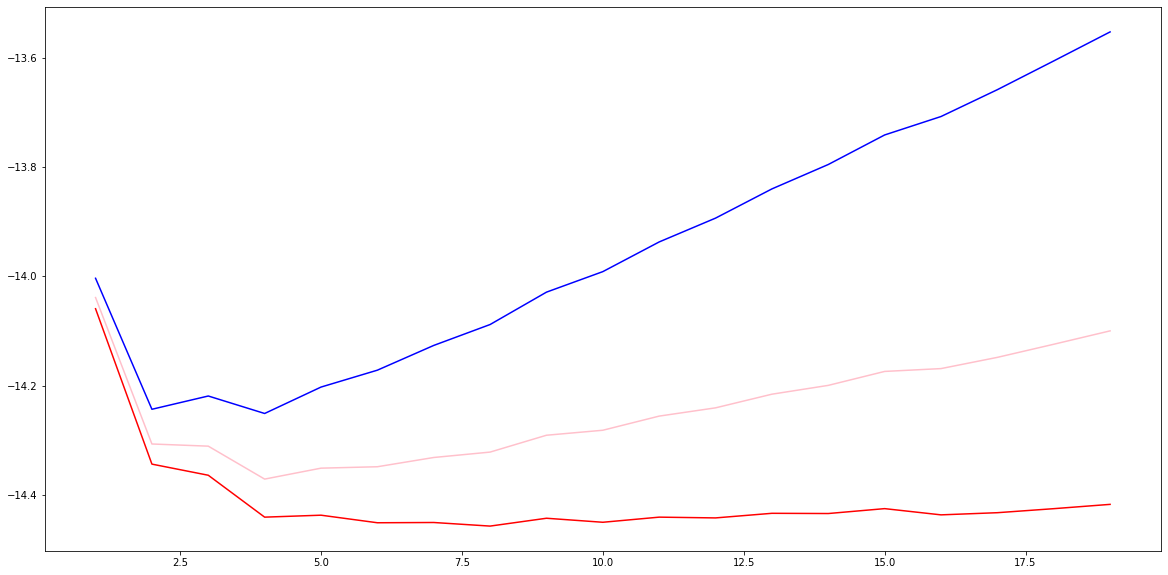

In [163]:
res_train.aic.plot(figsize = (20,10), color = "red")
res_train.bic.plot(color = "blue")
#res_train.fpe.plot(color = "green")
res_train.hqic.plot(color = "pink")
plt.show()

## Train the model

In [36]:
# model_fitted = model.fit(4)
# model_fitted.summary()

model_fitted = model.fit(maxlags=300, ic='aic')
# model_fitted = model.fit(maxlags=4)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 17, Jul, 2020
Time:                     16:04:49
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -11.7069
Nobs:                     2586.00    HQIC:                  -11.7763
Log likelihood:           4317.53    FPE:                7.38793e-06
AIC:                     -11.8157    Det(Omega_mle):     7.25248e-06
--------------------------------------------------------------------
Results for equation temperature
                    coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------
const                 -0.000086         0.001814           -0.048           0.962
L1.temperature         0.307911         0.019843           15.517           0.000
L1.humidity            0.048639         0.011430  

## Check for Serial Correlation of Residuals (Errors) using Durbin Watson Statistic

In [23]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(df.columns, out):
    print(col, ':', round(val, 2))

temperature : 2.0
humidity : 2.0
pressure : 2.0


## Forecast VAR model 

In [24]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 4

# Input data for forecasting
forecast_input = df_differenced.values[-lag_order:]
forecast_input

4


array([[-0.2, -0.1,  0. ],
       [-0.1,  0.1, -1. ],
       [-0.2,  0.1,  0. ],
       [ 0. , -0.1,  0. ]])

In [30]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=12)
df_forecast = pd.DataFrame(fc, index=df.index[-12:], columns=df.columns + '_1d')
df_forecast

,temperature_1d,humidity_1d,pressure_1d
time,,,
2020-07-17 12:40:00+00:00,-0.013157,0.008922,-0.021373
2020-07-17 12:45:00+00:00,0.002146,0.006795,0.028627
2020-07-17 12:50:00+00:00,0.011684,-0.014955,0.005851
2020-07-17 12:55:00+00:00,0.001803,-0.019442,-0.003844
2020-07-17 13:00:00+00:00,0.001242,-0.012078,-0.000160
2020-07-17 13:05:00+00:00,-0.000028,-0.007099,-0.002923
2020-07-17 13:10:00+00:00,-0.000597,-0.004516,-0.002247
2020-07-17 13:15:00+00:00,-0.000519,-0.003300,-0.001639
2020-07-17 13:20:00+00:00,-0.000521,-0.002098,-0.001705


## Invert the transformation to get the real forecast

In [31]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [32]:
df_results = invert_transformation(df_train, df_forecast, second_diff=False)  
#df_results.loc[:, ['temperature_forecast', 'humidity_forecast', 'pressure_forecast', 'people_forecast']]
df_results.loc[:, ['temperature_forecast', 'humidity_forecast', 'pressure_forecast']]

,temperature_forecast,humidity_forecast,pressure_forecast
time,,,
2020-07-17 12:40:00+00:00,29.586843,43.208922,1015.478627
2020-07-17 12:45:00+00:00,29.588988,43.215718,1015.507254
2020-07-17 12:50:00+00:00,29.600672,43.200763,1015.513105
2020-07-17 12:55:00+00:00,29.602475,43.181321,1015.509261
2020-07-17 13:00:00+00:00,29.603717,43.169243,1015.509101
2020-07-17 13:05:00+00:00,29.603689,43.162144,1015.506178
2020-07-17 13:10:00+00:00,29.603092,43.157627,1015.503930
2020-07-17 13:15:00+00:00,29.602573,43.154327,1015.502291
2020-07-17 13:20:00+00:00,29.602052,43.152229,1015.500586


## Plot of Forecast vs Actuals

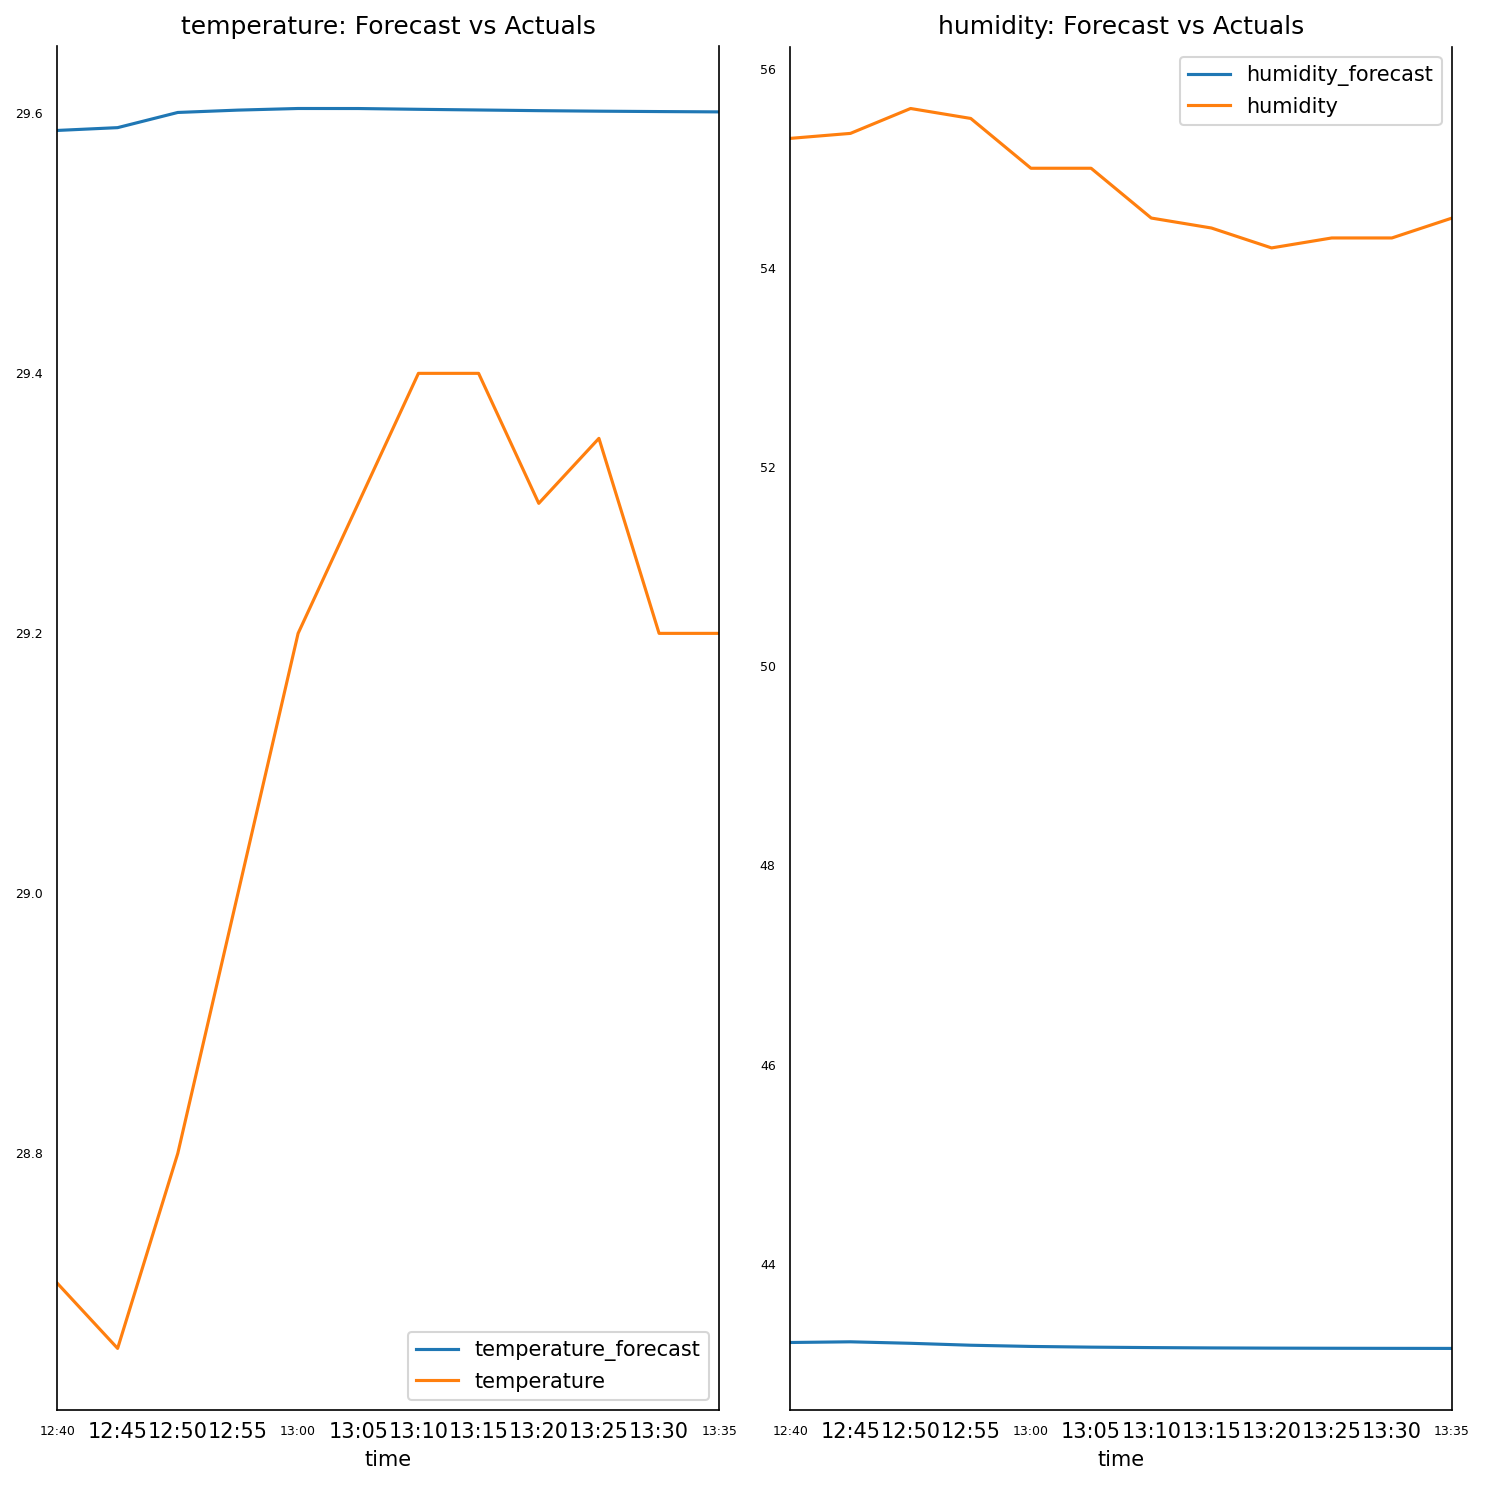

In [33]:
nobs=12
fig, axes = plt.subplots(nrows=int(len(df.columns)/2), ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [35]:
import numpy as np
from statsmodels.tsa.stattools import acf
from sklearn.metrics import mean_squared_error

def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    mse = mean_squared_error(actual, forecast)  # MSE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'mse':mse, 'rmse':rmse, 'corr':corr, 'minmax':minmax})

print('Forecast Accuracy of: temperature')
accuracy_prod = forecast_accuracy(df_results['temperature_forecast'].values, df_test['temperature'][:12])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

print('\nForecast Accuracy of: humidity')
accuracy_prod = forecast_accuracy(df_results['humidity_forecast'].values, df_test['humidity'][:12])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

print('\nForecast Accuracy of: pressure')
accuracy_prod = forecast_accuracy(df_results['pressure_forecast'].values, df_test['pressure'][:12])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

# print('\nForecast Accuracy of: people')
# accuracy_prod = forecast_accuracy(df_results['people_forecast'].values, df_test['people'][:288])
# for k, v in accuracy_prod.items():
#     print(k, ': ', round(v,4))


Forecast Accuracy of: temperature
mape :  0.0047
me :  -0.1335
mae :  0.14
mpe :  -0.0045
mse :  0.0312
rmse :  0.1766
corr :  0.4166
minmax :  0.0047

Forecast Accuracy of: humidity
mape :  0.0058
me :  0.0127
mae :  0.2524
mpe :  0.0004
mse :  0.1156
rmse :  0.34
corr :  -0.0741
minmax :  0.0058

Forecast Accuracy of: pressure
mape :  0.0
me :  0.0019
mae :  0.0067
mpe :  0.0
mse :  0.0001
rmse :  0.0088
corr :  nan
minmax :  0.0


/home/adamf42/.local/lib/python3.8/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/adamf42/.local/lib/python3.8/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
